In [1]:
import tensorflow as tf
model = tf.keras.models.load_model('/Users/gustavodias/Downloads/1abrilCFineTuning.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 450, 450, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 450, 450, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 450, 450, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 225, 225, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 225, 225, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 225, 225, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 112, 112, 128)     0   

In [2]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.11.0


1/1 [==============================] - 2s 2s/step
Predictions: [[9.9250197e-01 1.7129607e-09 5.5704191e-07 1.2711881e-03 6.2262164e-03]]
Predicted class: barroco


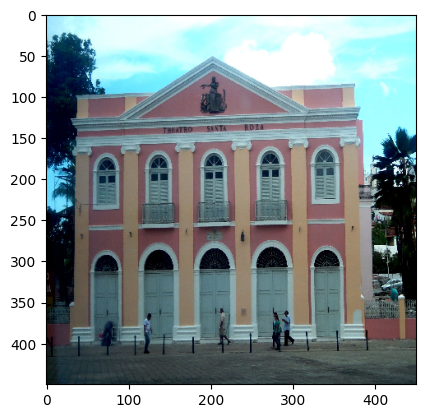

In [3]:
# Load the image
img = load_img('/Users/gustavodias/Downloads/Teatro_Santa_Rosa_-_João_Pessoa-1.JPG', target_size=(450, 450))
plt.imshow(img)

# Preprocess the image
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Make a prediction
predictions = model.predict(img_array)

print(f'Predictions: {predictions}')

# Interpret the prediction
class_idx = np.argmax(predictions)
class_names = ['barroco', 'ind', 'mod', 'neoclassica', 'neogotico']
predicted_class = class_names[class_idx]

print(f'Predicted class: {predicted_class}')


In [4]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [5]:
explainer = lime_image.LimeImageExplainer()

In [6]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(np.asarray(img), model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step
CPU times: user 19.2 s, sys: 11.4 s, total: 30.7 s
Wall time: 1min 18s


In [7]:
from skimage.segmentation import mark_boundaries

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

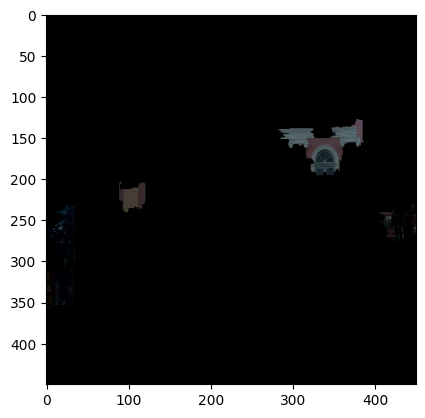

In [8]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))

Or with the rest of the image present:

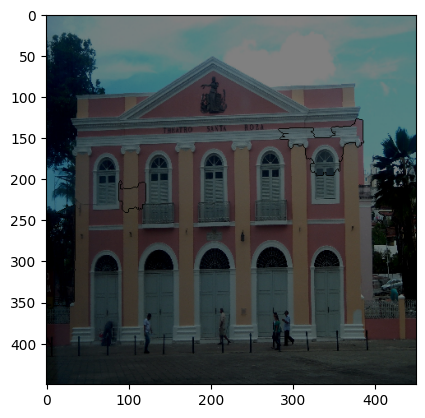

In [9]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))

We can also see the 'pros and cons' (pros in green, cons in red)

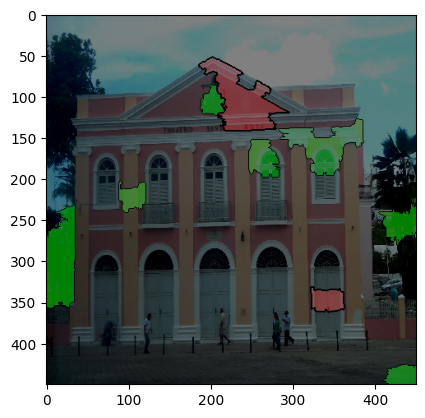

In [10]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))

Or the pros and cons that have weight at least 0.1

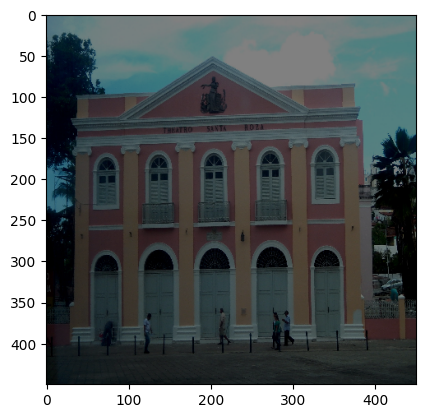

In [11]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))

Alternatively, we can also plot explanation weights onto a heatmap visualization. The colorbar shows the values of the weights.

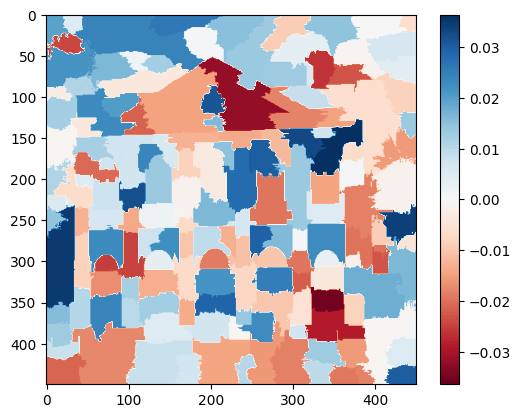

In [12]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [15]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
class_subset = sorted(os.listdir('/Users/gustavodias/Desktop/ArcStyles/train'))[1:6] # Using only the first 10 classes


train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

test_data_dir = '/Users/gustavodias/Desktop/ArcStyles/test'

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(450, 450),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 50 images belonging to 5 classes.


In [16]:
true_classes = testgen.classes
class_indices = testgen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

50/50 [==============================] - 4s 77ms/step


In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 94.00%


In [18]:
table = classification_report(true_classes, vgg_pred_classes)
print(table)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10
           3       0.89      0.80      0.84        10
           4       0.91      1.00      0.95        10

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50

